In [1]:
from netdeployonnx.client.experiment_helper import (  # noqa: F403
    get_data_overview,
    load_results,
    math,
    np,
    pd,
    plt,
    sns,
    stats,
)
from scipy.stats import ttest_1samp
from collections import defaultdict
from pathlib import Path
import os

#pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 130)

notebook_path = Path(os.getcwd())
results_path = notebook_path.parent.parent # we should be in /netdeployonnx/client/experiment.ipynb, so we end up in /
figures_path = results_path.parent.parent / "documentation" / "figures"
print(results_path, figures_path)
assert results_path.exists()
assert figures_path.exists(), f"{figures_path} does not exist"
assert str(figures_path).endswith('/_Masterarbeit_SS24/documentation/figures')

/home/vscode/_Masterarbeit_SS24/hannah-env/service /home/vscode/_Masterarbeit_SS24/documentation/figures


In [2]:
weights = defaultdict(lambda: 0)
nice_network_names = defaultdict(lambda: "")

nice_network_names.update({
    'cifar10_short.onnx':"CIFAR10 (5 Layer)",
    'cifar10.onnx':"CIFAR10",
    'ai85-bayer2rgb-qat8-q.pth.onnx':"Bayer2RGB",
    'ai85-cifar10-qat8-q.pth.onnx':"CIFAR10 quant.",
    'ai85-cifar100-qat8-q.pth.onnx':"CIFAR100 quant.",
    'ai85-faceid_112-qat-q.pth.onnx':"FACEID-112 quant.",
    'ai85-kws20_v3-qat8-q.pth.onnx':"KWS20v3 quant.",
})

weights.update({
    # "cifar10_short.onnx": 49152,
    # "cifar10.onnx": 302606,
    # "ai85-bayer2rgb-qat8-q.pth.onnx": 184,
    # "ai85-cifar10-qat8-q.pth.onnx": 303054,
    # "ai85-cifar100-qat8-q.pth.onnx": 349224,
    # "ai85-faceid_112-qat-q.pth.onnx": 893585,
    # "ai85-kws20_v3-qat8-q.pth.onnx": 170127,
    "cifar10_short.onnx": 42944, # 200_000
    "cifar10.onnx": 302602,
    "ai85-bayer2rgb-qat8-q.pth.onnx": 99,
    "ai85-cifar10-qat8-q.pth.onnx": 302602,
    "ai85-cifar100-qat8-q.pth.onnx": 348772,
    "ai85-faceid_112-qat-q.pth.onnx": 892016,
    "ai85-kws20_v3-qat8-q.pth.onnx": 170125,
})

nice_colnames = {
    '_check_model': "Model validation",
    'layout_transform':'Transforming the network',
    'compile_instructions':'Compilation of  Instructions',
    'execute':'Execution and device information transfer',
    }
nice_metrics = {
    'inference': "Inference",
    'weights_loading': "Loading of Weights",
    'input_loading': "Loading of Inputs",
}

In [5]:
df = load_results(results_path / "results_npu.yaml")
list(df.keys())
df['experiment_idx'] = pd.factorize(df['experiment'])[0]
df['network_idx'] = pd.factorize(df['option_network_name'])[0]
df_filtered = df.drop(columns=[
    'experiment',
    'date',
    'samplepoints',
    'option_network_name'
    ])
for column_name in df_filtered.columns:
    # df_filtered[column_name] = pd.to_numeric(df_filtered[column_name])
    if df_filtered[column_name].dtype == 'bool':
        df_filtered[column_name] = df_filtered[column_name].astype('int64')

assert all(x in ['int64', 'float64'] for x in df_filtered.dtypes)
df['option_network_name'].unique()
df['network_size'] = df['option_network_name'].apply(lambda x:weights[x])
df = df.sort_values(by=['network_size'])

/tmp/ipykernel_4051505/623962306.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  relative_diffs = grouped.drop(columns=grouped_with_zero).pct_change().dropna()
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/vscode/_Masterarbeit_SS24/hannah-env/service/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in div

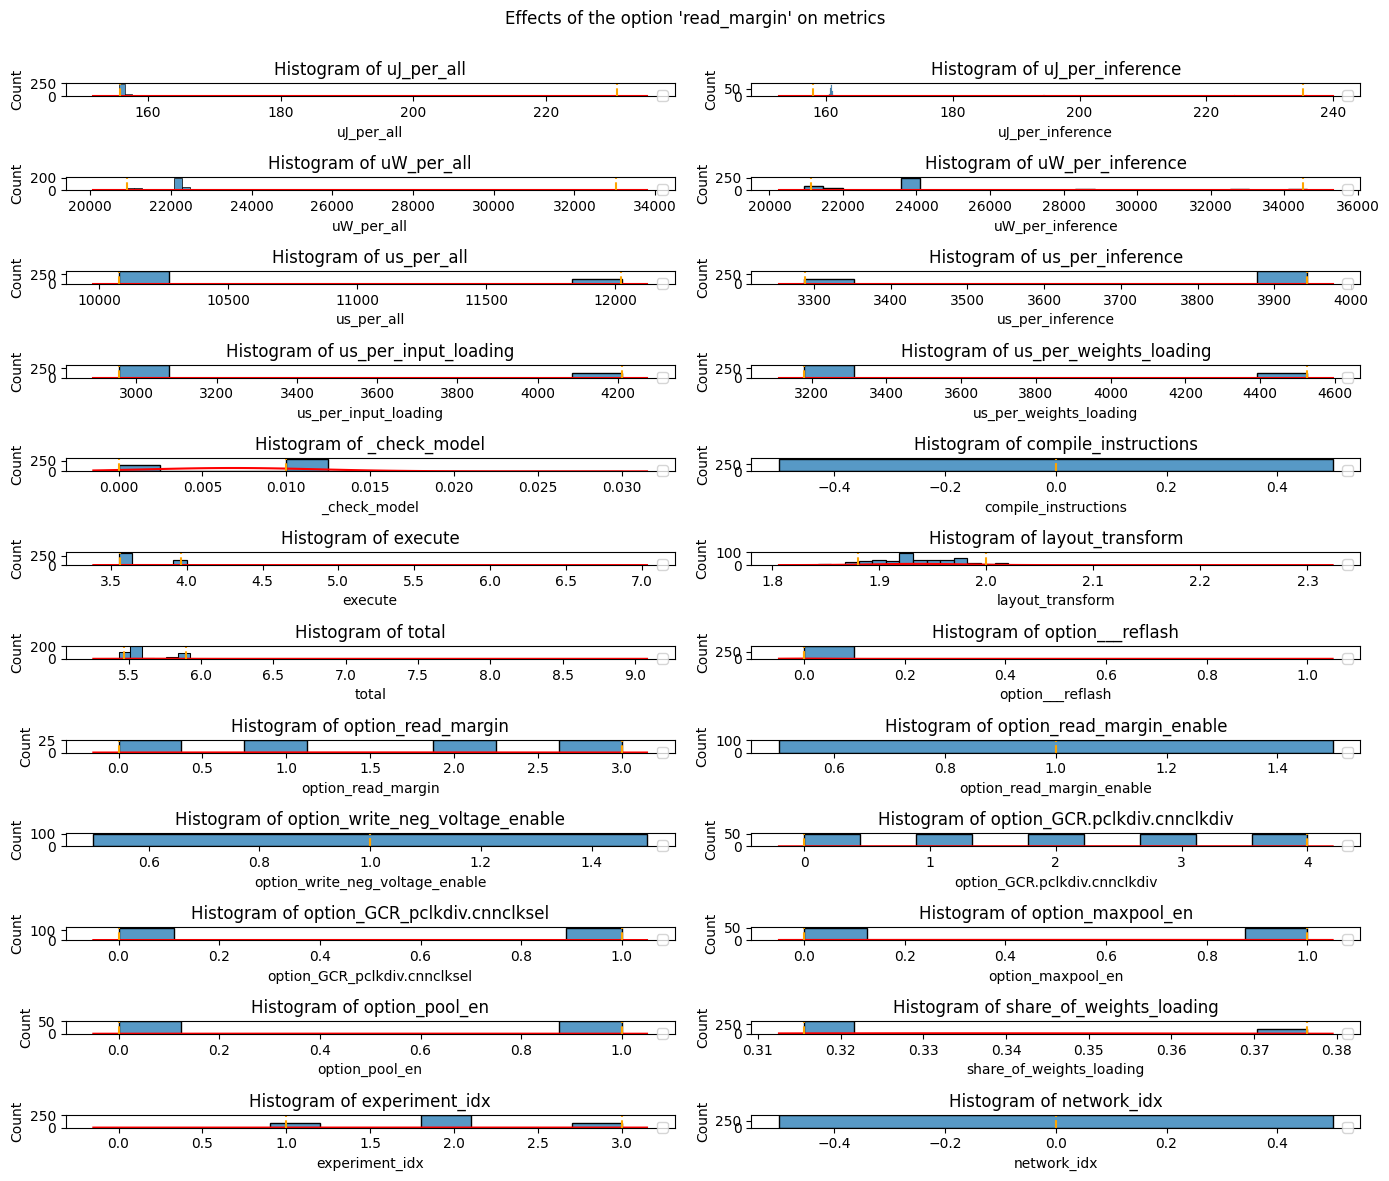

In [6]:
quantil = 0.95

def check_for_flash_vs_noflash():
    # can i see a difference between with and without flashing
    grouped = df.groupby(['experiment_idx', 'option___reflash']).mean('deploy').reset_index()
    # relative = grouped.pct_change()
    grouped_with_zero = [col for col in grouped.columns if (grouped[col] == 0).any()]
    relative_diffs = grouped.drop(columns=grouped_with_zero).pct_change().dropna()
    assert all(relative_diffs < 0.01) # diff is smaller than 1%

check_for_flash_vs_noflash()
data_overview_plot = get_data_overview(df_filtered.drop(columns=['uJ_per_input_loading', 'uJ_per_weights_loading','uW_per_input_loading', 'uW_per_weights_loading']))


In [33]:
# Create clock frequency mapping dictionaries
clkdiv_dict = {0: 2, 1: 4, 2: 8, 3: 16, 4: 1}  # Changed values based on documentation
clksel_dict = {0: 100, 1: 60}   # This was correct

# Filter for rows that have both clock-related columns
clock_experiments = df_filtered.dropna(subset=['option_GCR.pclkdiv.cnnclkdiv', 
                                             'option_GCR_pclkdiv.cnnclksel'])

# Calculate clock frequency only for relevant experiments
def calculate_clock_freq(row):
    try:
        div = clkdiv_dict[int(row['option_GCR.pclkdiv.cnnclkdiv'])]
        sel = clksel_dict[int(row['option_GCR_pclkdiv.cnnclksel'])]
        return sel / div
    except (KeyError, ValueError):
        return None

# Add clock frequency column
clock_experiments['clock_freq'] = clock_experiments.apply(calculate_clock_freq, axis=1)
# Add separate columns for clarity
clock_experiments['base_clock'] = clock_experiments['option_GCR_pclkdiv.cnnclksel'].map(clksel_dict)
clock_experiments['divider'] = clock_experiments['option_GCR.pclkdiv.cnnclkdiv'].map(clkdiv_dict)

/tmp/ipykernel_4051505/2835875788.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clock_experiments['clock_freq'] = clock_experiments.apply(calculate_clock_freq, axis=1)
/tmp/ipykernel_4051505/2835875788.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clock_experiments['base_clock'] = clock_experiments['option_GCR_pclkdiv.cnnclksel'].map(clksel_dict)
/tmp/ipykernel_4051505/2835875788.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [35]:
# Group by clock frequency and calculate mean and std for key metrics

# Analyze for each base clock
for base_clock in [60, 100]:
    subset = clock_experiments[clock_experiments['base_clock'] == base_clock]
    
    print(f"\nAnalysis for {base_clock}MHz base clock:")
    
    # Summary stats by divider
    stats = subset.groupby('divider').agg({
        'us_per_inference': ['mean', 'std'],
        'uW_per_inference': ['mean', 'std'],
        'us_per_all': ['mean', 'std'],
        'uW_per_all': ['mean', 'std'],
    }).round(3)
    
    print("\nSummary by divider:")
    print(stats)
    
    # ANOVA for dividers
    f_stat_time, p_val_time = scipy_stats.f_oneway(
        *[group['us_per_inference'].values for name, group in subset.groupby('divider')]
    )
    
    print(f"\nANOVA p-value for dividers: {p_val_time:.4f}")


Analysis for 60MHz base clock:

Summary by divider:
        us_per_inference        uW_per_inference          us_per_all        uW_per_all         
                    mean    std             mean      std       mean    std       mean      std
divider                                                                                        
1               3288.028  0.355        21379.568  295.881  12019.668  2.164  21172.176  298.706
2               3288.645  0.337        21425.664  225.762  12021.541  2.173  21225.996  224.864
4               3288.507  0.347        21336.768  223.587  12020.945  2.260  21133.632  222.814
8               3288.124  0.245        21342.736  258.671  12019.764  2.272  21139.056  255.738
16              3288.218  0.345        21441.632  238.089  12019.811  2.036  21235.892  231.259

ANOVA p-value for dividers: 0.0000

Analysis for 100MHz base clock:

Summary by divider:
        us_per_inference        uW_per_inference         us_per_all        uW_per_all    

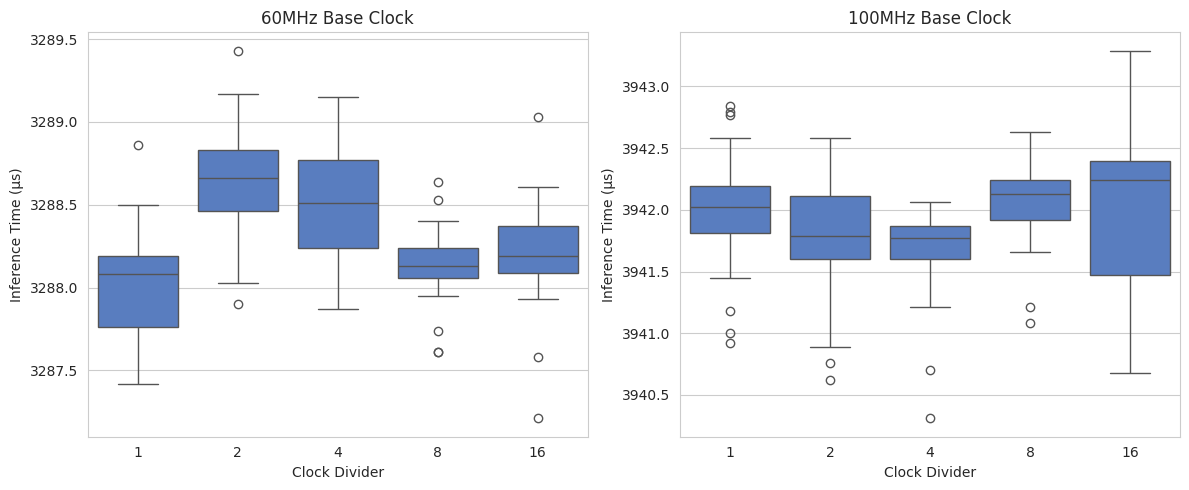


100MHz means by divider:
divider
1     3942.0024
2     3941.7784
4     3941.6464
8     3942.0696
16    3941.9632
Name: us_per_inference, dtype: float64


In [36]:
# Create boxplots separated by base clock to see the divider effects
plt.figure(figsize=(12, 5))

# Plot for 60MHz and 100MHz side by side
plt.subplot(1, 2, 1)
sns.boxplot(data=clock_experiments[clock_experiments['base_clock'] == 60], 
            x='divider', y='us_per_inference')
plt.title('60MHz Base Clock')
plt.xlabel('Clock Divider')
plt.ylabel('Inference Time (µs)')

plt.subplot(1, 2, 2)
sns.boxplot(data=clock_experiments[clock_experiments['base_clock'] == 100], 
            x='divider', y='us_per_inference')
plt.title('100MHz Base Clock')
plt.xlabel('Clock Divider')
plt.ylabel('Inference Time (µs)')

plt.tight_layout()
plt.show()

# Print mean values for 100MHz to see if there's any trend despite non-significance
print("\n100MHz means by divider:")
print(clock_experiments[clock_experiments['base_clock'] == 100].groupby('divider')['us_per_inference'].mean())

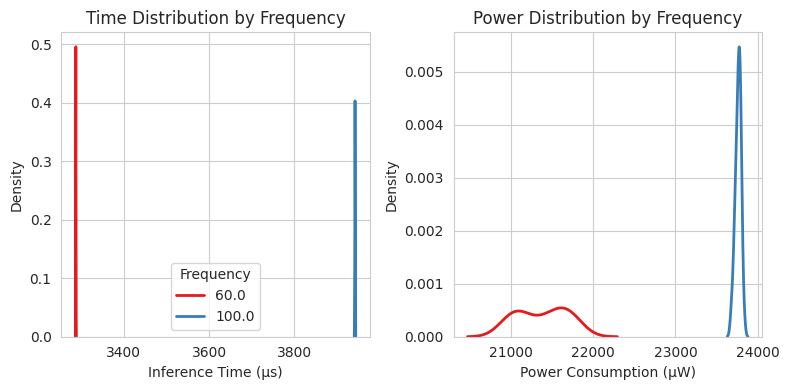

In [134]:
# Set rainbow palette with explicit color mapping
unique_freqs = sorted(clock_data['freq'].unique())
base_clock_data = clock_data[clock_data['freq'].isin([60, 100])]
rainbow_palette = 'Set1' # dict(zip(unique_freqs, sns.color_palette('rainbow', n_colors=len(unique_freqs))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Time distribution
sns.kdeplot(data=base_clock_data, x='us_per_inference', hue='freq', 
           palette=rainbow_palette, ax=ax1, linewidth=2)
ax1.set_title('Time Distribution by Frequency')
ax1.set_xlabel('Inference Time (µs)')
leg = ax1.get_legend()
leg.set_title("Frequency")

# Power distribution
sns.kdeplot(data=base_clock_data, x='uW_per_inference', hue='freq', 
           palette=rainbow_palette, ax=ax2, linewidth=2, legend=False)
ax2.set_title('Power Distribution by Frequency')
ax2.set_xlabel('Power Consumption (µW)')

plt.tight_layout()
plt.savefig(figures_path / "05_npu_clockdividers.pdf", format='pdf', bbox_inches='tight')

In [31]:
# Filter for only base clocks (60 and 100 MHz)
base_clock_data = clock_data[clock_data['freq'].isin([60, 100])]

# Calculate metrics per MHz
base_clock_data['time_per_MHz'] = base_clock_data['us_per_inference'] / base_clock_data['freq']
base_clock_data['power_per_MHz'] = base_clock_data['uW_per_inference'] / base_clock_data['freq']

# Print summary statistics
print("Summary statistics by frequency:")
print(base_clock_data.groupby('freq')[['time_per_MHz', 'power_per_MHz']].agg(['mean', 'std']).round(3))

Summary statistics by frequency:
      time_per_MHz        power_per_MHz       
              mean    std          mean    std
freq                                          
60.0         54.80  0.006       356.326  4.931
100.0        39.42  0.005       237.630  0.340


/tmp/ipykernel_4051505/3647561307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_clock_data['time_per_MHz'] = base_clock_data['us_per_inference'] / base_clock_data['freq']
/tmp/ipykernel_4051505/3647561307.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_clock_data['power_per_MHz'] = base_clock_data['uW_per_inference'] / base_clock_data['freq']


/tmp/ipykernel_4051505/517450610.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margin_data['read_margin'] = margin_data['option_read_margin'].map(margin_labels)
/tmp/ipykernel_4051505/517450610.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels([f'{y}' for y in y3_ticks])
/tmp/ipykernel_4051505/517450610.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_yticklabels([f'{y}' for y in y4_ticks])


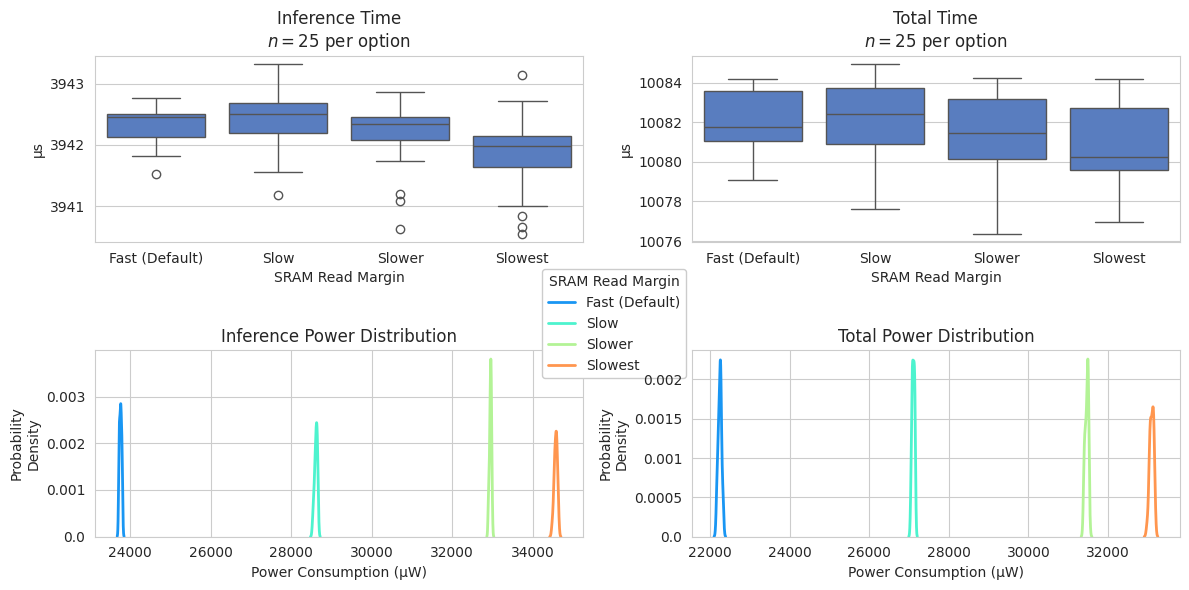

In [119]:
margin_labels = {
   0: 'Slowest',
   1: 'Slower',
   2: 'Slow',
   3: 'Fast (Default)',
}

margin_data = df_filtered.dropna(subset=['option_read_margin'])
margin_data['read_margin'] = margin_data['option_read_margin'].map(margin_labels)

samples_per_option = margin_data['read_margin'].value_counts()
title_suffix = f'\n$n=25$ per option'

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))

# Time boxplots
sns.boxplot(data=margin_data, x='read_margin', y='us_per_inference', ax=ax1)
ax1.set_title(f'Inference Time{title_suffix}')
ax1.set_ylabel('µs')
ax1.set_xlabel('SRAM Read Margin')

sns.boxplot(data=margin_data, x='read_margin', y='us_per_all', ax=ax2)
ax2.set_title(f'Total Time{title_suffix}')
ax2.set_ylabel('µs')
ax2.set_xlabel('SRAM Read Margin')

# Power distributions
unique_margins = sorted(margin_data['read_margin'].unique())
rainbow_palette = dict(zip(unique_margins, sns.color_palette('rainbow', n_colors=len(unique_margins))))

n_samples = len(margin_data)

# Create KDE plots and save the legend handles from one plot
kde1 = sns.kdeplot(data=margin_data, x='uW_per_inference', hue='read_margin',
                  palette=rainbow_palette, ax=ax3, linewidth=2, legend=True)
ax3.set_title('Inference Power Distribution')
ax3.set_xlabel('Power Consumption (µW)')


# Add a single legend at the bottom center
handles, labels = ax3.get_legend_handles_labels()
y3_ticks = ax3.get_yticks()
ax3.set_yticklabels([f'{y}' for y in y3_ticks])
ax3.set_ylabel('Probability\nDensity')

kde2 = sns.kdeplot(data=margin_data, x='uW_per_all', hue='read_margin', 
                  palette=rainbow_palette, ax=ax4, linewidth=2, legend=False)
ax4.set_title('Total Power Distribution')
ax4.set_xlabel('Power Consumption (µW)')
y4_ticks = ax4.get_yticks()
ax4.set_yticklabels([f'{y}' for y in y4_ticks])
ax4.set_ylabel('Probability\nDensity')


# Get and modify legend
leg = ax3.get_legend()
leg.set_bbox_to_anchor((0.45, 0.35), transform=fig.transFigure) # Center of figure
leg.set_title('SRAM Read Margin')
leg.set_zorder(1000)  # Set high z-index to show legend on top
leg.get_frame().set_alpha(1.0)  # Make legend background fully opaque
leg.get_frame().set_facecolor('white')  # Ensure white background

plt.subplots_adjust(wspace=-0.5, right=0.95, left=0.05)
plt.tight_layout()

plt.savefig(figures_path / "05_npu_read_margin.pdf", format='pdf', bbox_inches='tight')